Importing Packages And Basic Set up

In [27]:
#.venv/scripts/activate  ; no source. 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss

import numpy as np
import pandas as pd

Importing Datasets

In [28]:
# Importing maindata
file_path = "C://Users/miste/Documents/Causal_ML/"
x = pd.read_stata(file_path + "maindata.dta", convert_categoricals=False)

# Importing laws_csv, cleaning it
laws_csv = pd.read_csv(file_path + "When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.drop("State_Name", axis=1)  # Dropping as useless
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

Cleaning Datasets, only interested in the 1997 states. 

In [29]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think

# Dropping states who were treated < 97 (i.e. they always had programs)
# This is following Callaway + Sant'anna, as we cannot meaningfully 
# do any inference using those states. Although we can compare them later as a 
# robustness check, which may be interesting
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# Making it so that "never-treated" states are treated at T = infinity
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to int


# indicator for if treatment has occured in state i

# Indicator for if the individual was treated (i.e. under 19 and in a state who added a law)
basic_merged["treatment"] = basic_merged["under19"] # * basic_merged["year_indic"]


# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["year", "stfips", "fownu18", "faminctm1", "a_maritl", "female" , "fpovcut", "povll"]
list_of_confounders += ["anykids", "disability", "noemp_insured"]


$\underline{\bold{\text{Estimating causal effect}}}$

Subsetting data

Fitting Model

In [30]:
def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, year_of_interest:int):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    '''
    ### THIS ONE DEF WORKS WITH THE OLD THINGIE. ou
    # Setting up prediction vectors
    # the 2*i'th column is year `i` with treatment = 0
    # the (2*i)+1'th column is year `i` with treatment = 1
    predictions_matrix = np.empty(shape=(y.shape[0], 36))

    # k-folding
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    year_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)
    treat_vec = np.full_like(X_w_treatment["year"], np.nan, dtype=float)

    X_w_treatment["year"] = X_w_treatment["year"] - (year_of_interest - 1)
    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        q = make_model()
        q.fit(X_train, y_train)

        # This saves the vector of years so we only get the att for the 1997 group
        year_vec[test_index] =  X_w_treatment["year"].loc[test_index]

        # This saves the vector of treated statuses, as we want to condition on A = 1
        treat_vec[test_index] = A.loc[test_index]
        for j in range(1991, 2009):
            # for predicting effect under treatment / control status for each data point
            X0 = X_w_treatment.copy()
            X0["A"] = 0
            X0["year"] = j - (year_of_interest-1)
            col_num = 2*(j - 1991)
            predictions_matrix[test_index,col_num] = q.predict_proba(X0.loc[test_index])[:, 1]
        for j in range(1991,2009):
            X1 = X_w_treatment.copy()
            X1["A"] = 1
            X1["year"] = j - (year_of_interest-1)
            col_num = 2*(j - 1991) + 1
            predictions_matrix[test_index,col_num] = q.predict_proba(X1.loc[test_index])[:, 1]

    assert np.isnan(predictions_matrix).sum() == 0
    print(year_vec)
    return predictions_matrix, year_vec, treat_vec

def make_Q_model():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return RandomForestClassifier(max_depth=5, n_estimators=100)

Estimating the ATT's


In [31]:
def ATT_event_study(stfips:int, year_of_interest:int, outcome:str):
    mean_list = np.zeros(17)  # Will end up being a list of the average ATT's
    ste_list = np.zeros(17)  # Will end up being a list of the standard errors. 
    state_level = basic_merged[basic_merged["stfips"] == stfips]

    # outcome in  ["pubonly", "insured", "privonly"]
    state_level = state_level[list_of_confounders + ["treatment", outcome]]

    # Drop missings
    state_level = state_level.dropna(axis = 0)

    # Setting up 
    state_level = state_level.reset_index(drop=True)
    confounders = state_level[list_of_confounders]
    treatment = state_level['treatment']
    outcome = state_level[outcome]

    # Fitting
    predictions_matrix, year_vec, treat_vec = outcome_k_fold_fit_and_predict(make_Q_model, \
                                        X=confounders, y=outcome, A=treatment,  n_splits=5, \
                                        year_of_interest=year_of_interest) 
    # the 2*i'th column is always the untreated vec, and the (2*i)+1 is treated. 
    weight = (year_vec == 1) * (treat_vec == 1) # We only want the ATT, so we weight appropriately
                                                # to only look at the untils treated at t=1
    weight = weight / np.mean(weight)
    
    for i in range(1,18): # we look at the ATT for 1993-2008 (cannot look at 1992 as we have no 1991 data)
        year = i + 1991 
        term_1 = predictions_matrix[:,(2*i)+1]  # m_treat_1
        term_3 = predictions_matrix[:,(2*i)]    # m_nev_1
        if year >= year_of_interest: # If we've gotten to the treatment year 
            term_2 = predictions_matrix[:,(2*(year_of_interest-1992))-1]  # m_treat_0
            term_4 = predictions_matrix[:,(2*(year_of_interest-1992))-2]  # m_nev_0
        else:  # otherwise we do a short difference. 
            term_2 = predictions_matrix[:,(2*i)-1]  # m_treat_0
            term_4 = predictions_matrix[:,(2*i)-2]  # m_nev_0
        final = weight * (term_1 - term_2 - (term_3 - term_4))
        # Multiplying by 100 to convert to %
        mean_list[i-1] += np.mean(final) * 100
        ste_list[i-1] += np.std(final) * 100 / np.sqrt(term_1.shape[0])
    return mean_list, ste_list

[11. 11. 12. ...  1.  5.  1.]
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


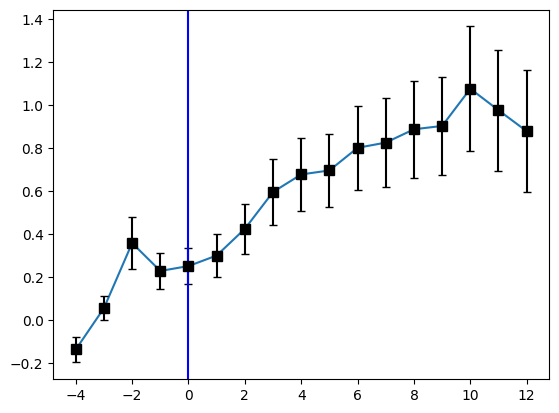

In [32]:
mean_list, ste_list = ATT_event_study(stfips=16, year_of_interest=1997, outcome="insured")

# Plotting
# Treatment occurs at t = 1
x = np.arange(1992- 1996, 2009-1996, 1) # I missed up length :/
ste_list = [x *1.96 for x in ste_list]
plt.plot(x, mean_list)
# Computing the actual CI's/error bars -- the thing before was just the radius. 
for i in range(len(mean_list)):
    corresponding_year = i + 1992 - 1996
    plt.errorbar(x=corresponding_year, y=mean_list[i], yerr=ste_list[i], \
                 color="black", capsize=3, linestyle="None",\
                marker="s", markersize=7, mfc="black", mec="black")

# Line which indicates after when treatment occurs. 
plt.axvline(x=0, color='b')

plt.show() 